In [1]:
import glob, os, sys
sys.path.append("..")
from utils.utils import *
import uproot, ROOT, random, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from xgboost import XGBClassifier 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set up plot defaults
import matplotlib as mpl

# mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
# mpl.rcParams['font.size'] = 14.0 # Use 14 point font
# sns.set(style="whitegrid")

Welcome to JupyROOT 6.30/04


In [2]:
Ztt_inc = [
    # mc23 DSIDs
    # 700621, 700622, 700623, 
    # 700642, 700643, 700644,
    # 700703, 700704, 700705,
    # mc20 DSIDs
    700792, 700793, 700794,
    700360, # Ztautau2jets
    ]

ttV = [
    410155, # ttW
    # 410218, 410219, 410220, # ttZ
    304014, # 3t, 4t #! missing these samples
    ]

# Diboson
VV = [
    700488, 700489, 
    700491, 700492, 700493, 700494, 700495, 700496,
    700600, 700601, 700602, 700603, 700604, 700605, 
]

# Single-Top and ttbar (new samples now!)
Top = [
    410470, 410471, 
    # 410472, 
    410644, 410645, 410646, 410647, 
    410658, 410659
]

# W(tau/mu/e + nu) + jets
W = [
    700338, 700339, 700340, # Wenu
    700341, 700342, 700343, # Wmunu #! 700342 is missing (should be okay... basically no W)
    700344, 700345, 700346, # WtaunuL
    700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
    700362, 700363, 700364, # W lep + 2jets
]

Zll_inc = [
    700320, 700321, 700322, # Zee 
    700323, 700324, 700325, # Zmumu
    700358, #Zee2jets
    700359, #Zmumu2jets
]

Zee = [
    700320, 700321, 700322, # Zee
    700358, # Zee2jets
]

Zmumu = [
    700323, 700324, 700325, # Zmumu
    700359, # Zmumu2jetss
]

# Signal samples (new)
ggH = [
    345120, 345121, 345122, 345123
    ]
VBFH = [
    # mc20 DSIDs
    346190, 346191, 346192, 346193,
]
WH = [345211, 345212]
ZH = [345217]
ttH = [346343,346344,346345]

LUMI = {
    '15': 3244.54,
    '16': 33402.2,
    '17': 44630.6,
    '18': 58791.6,    
}

LUMI_SCALE = {
    '15': (3244.54+33402.2)/3244.54,
    '16': (3244.54+33402.2)/33402.2,
    '17': 1,
    '18': 1,
}

In [3]:
def read_event_weights(event_id, data_year):
    file_path = './xsec_sumofweights_nom.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])

    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            results[event_id] = event_weight / sum_event_weights
    return results
            
#signal
vbfh_ws_e = fetch_weights(VBFH, 'mc20e')
ggh_ws_e = fetch_weights(ggH, 'mc20e')
wh_ws_e = fetch_weights(WH, 'mc20e')
zh_ws_e = fetch_weights(ZH, 'mc20e')
tth_ws_e = fetch_weights(ttH, 'mc20e')
#background
ztt_ws_e = fetch_weights(Ztt_inc, 'mc20e')
ttv_ws_e = fetch_weights(ttV, 'mc20e')
vv_ws_e = fetch_weights(VV, 'mc20e')
top_ws_e = fetch_weights(Top, 'mc20e')
w_ws_e = fetch_weights(W, 'mc20e')
zll_ws_e = fetch_weights(Zll_inc, 'mc20e')

In [4]:
vbfh_ws_d = fetch_weights(VBFH, 'mc20d')
ggh_ws_d = fetch_weights(ggH, 'mc20d')
wh_ws_d = fetch_weights(WH, 'mc20d')
zh_ws_d = fetch_weights(ZH, 'mc20d')
tth_ws_d = fetch_weights(ttH, 'mc20d')
ztt_ws_d = fetch_weights(Ztt_inc, 'mc20d')
ttv_ws_d = fetch_weights(ttV, 'mc20d')
vv_ws_d = fetch_weights(VV, 'mc20d')
top_ws_d = fetch_weights(Top, 'mc20d')
w_ws_d = fetch_weights(W, 'mc20d')
zll_ws_d = fetch_weights(Zll_inc, 'mc20d')

vbfh_ws_a = fetch_weights(VBFH, 'mc20a')
ggh_ws_a = fetch_weights(ggH, 'mc20a')
wh_ws_a = fetch_weights(WH, 'mc20a')
zh_ws_a = fetch_weights(ZH, 'mc20a')
tth_ws_a = fetch_weights(ttH, 'mc20a')
ztt_ws_a = fetch_weights(Ztt_inc, 'mc20a')
ttv_ws_a = fetch_weights(ttV, 'mc20a')
vv_ws_a = fetch_weights(VV, 'mc20a')
top_ws_a = fetch_weights(Top, 'mc20a')
w_ws_a = fetch_weights(W, 'mc20a')
zll_ws_a = fetch_weights(Zll_inc, 'mc20a')

In [5]:
branches = \
[
'ditau_obj_truth_leadTau_p4',
'ditau_obj_truth_subleadTau_p4',
'boson_0_classifierParticleOrigin',
'boson_0_mother_pdgId',
'boson_0_mother_status',
'boson_0_pdgId',
'boson_0_truth_pdgId',
'boson_0_truth_q',
'boson_0_truth_status',
'boson_0_q',
'ditau_obj_IsTruthMatched',
'ditau_obj_IsTruthHadronic',
'ditau_obj_truth_p4',
'met_truth_p4',

#  'mlp_scores',
 'NOMINAL_pileup_random_run_number',
 'ditau_obj_bdt_score',
#  'ditau_obj_charge',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
#  'ditau_obj_n_iso_tracks',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
#  'ditau_obj_subjets_dR',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'event_number',
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'NOMINAL_pileup_combined_weight',
 'n_bjets_DL1dv01_FixedCutBEff_70',
 'weight_mc']

data_branches = \
[
#  'mlp_scores',
 'event_number',    
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'ditau_obj_bdt_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [6]:
# path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/mc/ditau_hh/mc20e/nom/user.shhirose.*{dsid}.*/user.*.root'
# path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/mc/ditau_hh/mc20e/nom/user.shhirose.*{dsid}.*/user.*.root'
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/mc/ditau_hh/{year}/nom/user.shhirose.*{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws, year_id='mc20e', year='18'):
    out = []
    hlt_branches = {
        '15': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'],
        '16': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'],
        '17': ['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100'],
        '18': ['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    }
    
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid, year=year_id)
        files = glob.glob(file_pattern)
        s = time.time()
        
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                branches_read = branches + hlt_branches.get(year, [])
                events = f_1.arrays(branches_read, library='ak')

                # Handling 2015 and 2016 conditions
                if year in ['15', '16']:
                    mask_15 = (events['NOMINAL_pileup_random_run_number'] <= 284484) & (events['NOMINAL_pileup_random_run_number'] > 0)
                    mask_16 = (events['NOMINAL_pileup_random_run_number'] > 284484) & (events['NOMINAL_pileup_random_run_number'] <= 311563)

                    events['weight'] = mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks']) * events['weight_mc'] * events['NOMINAL_pileup_combined_weight']

                    # Assign weights based on the run number
                    events['weight'] = ak.where(mask_15,
                                                events['weight'] * LUMI_SCALE['15'] * LUMI['15'],
                                                ak.where(mask_16,
                                                         events['weight'] * LUMI_SCALE['16'] * LUMI['16'],
                                                         events['weight']))
                    
                    if not ak.any(mask_15 | mask_16):
                        print(f"Event number out of range in file: {file}")
                
                elif year in ['17', '18']:
                    events['weight'] = (mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])) * \
                                       events['weight_mc'] * events['NOMINAL_pileup_combined_weight'] * \
                                       LUMI_SCALE[year] * LUMI[year]
                
                out = ak.concatenate((out, events))

        print(f"Processed year: {year}, files for DSID {dsid_list}, Time spent: {round(time.time()-s, 4)} s")
    
    return out


vbfh_e = read_root(VBFH, vbfh_ws_e, year_id='mc20e', year='18')
ggh_e = read_root(ggH, ggh_ws_e, year_id='mc20e', year='18')
wh_e = read_root(WH, wh_ws_e, year_id='mc20e', year='18')
zh_e = read_root(ZH, zh_ws_e, year_id='mc20e', year='18')
tth_e = read_root(ttH, tth_ws_e, year_id='mc20e', year='18')
ztt_e = read_root(Ztt_inc, ztt_ws_e, year_id='mc20e', year='18')
ttv_e = read_root(ttV, ttv_ws_e, year_id='mc20e', year='18')
vv_e = read_root(VV, vv_ws_e, year_id='mc20e', year='18')
top_e = read_root(Top, top_ws_e, year_id='mc20e', year='18')
w_e = read_root(W, w_ws_e, year_id='mc20e', year='18')
zll_e = read_root(Zll_inc, zll_ws_e, year_id='mc20e', year='18')

vbfh_d = read_root(VBFH, vbfh_ws_d, year_id='mc20d', year='17')
ggh_d = read_root(ggH, ggh_ws_d, year_id='mc20d', year='17')
wh_d = read_root(WH, wh_ws_d, year_id='mc20d', year='17')
zh_d = read_root(ZH, zh_ws_d, year_id='mc20d', year='17')
tth_d = read_root(ttH, tth_ws_d, year_id='mc20d', year='17')
ztt_d = read_root(Ztt_inc, ztt_ws_d, year_id='mc20d', year='17')
ttv_d = read_root(ttV, ttv_ws_d, year_id='mc20d', year='17')
vv_d = read_root(VV, vv_ws_d, year_id='mc20d', year='17')
top_d = read_root(Top, top_ws_d, year_id='mc20d', year='17')
w_d = read_root(W, w_ws_d, year_id='mc20d', year='17')
zll_d = read_root(Zll_inc, zll_ws_d, year_id='mc20d', year='17')

vbfh_a = read_root(VBFH, vbfh_ws_a, year_id='mc20a', year='15')
ggh_a = read_root(ggH, ggh_ws_a, year_id='mc20a', year='15')
wh_a = read_root(WH, wh_ws_a, year_id='mc20a', year='15')
zh_a = read_root(ZH, zh_ws_a, year_id='mc20a', year='15')
tth_a = read_root(ttH, tth_ws_a, year_id='mc20a', year='15')
ztt_a = read_root(Ztt_inc, ztt_ws_a, year_id='mc20a', year='15')
ttv_a = read_root(ttV, ttv_ws_a, year_id='mc20a', year='15')
vv_a = read_root(VV, vv_ws_a, year_id='mc20a', year='15')
top_a = read_root(Top, top_ws_a, year_id='mc20a', year='15')
w_a = read_root(W, w_ws_a, year_id='mc20a', year='15')
zll_a = read_root(Zll_inc, zll_ws_a, year_id='mc20a', year='15')


Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.1444 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.1384 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.1382 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.338 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.7484 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.2776 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.4025 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.3533 s
Processed year: 18, files for DSID [345211, 345212], Time spent: 0.1318 s
Processed year: 18, files for DSID [345211, 345212], Time spent: 0.2713 s
Processed year: 18, files for DSID [345217], Time spent: 0.1417 s
Processed year: 18, files for DSID [346343, 346344, 346345], Time s

In [7]:
## load data
# path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/*.root'
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data{year}/user.shhirose.Httbst*/*.root'

def read_data_root(year='18'):
    file_paths = path_template_data.format(year=year)
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        f_1 = uproot.open(l1[i]+':NOMINAL')
        #if file is empty skip
        if f_1.num_entries == 0:
            continue
        branches_read = []
        branches_read.extend(data_branches)
        if year == '15':
            branches_read.extend(['HLT_j360'])
        elif year == '16':
            branches_read.extend(['HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'])
        elif year == '17':
            branches_read.extend(['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100'])
        elif year == '18':
            branches_read.extend(['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111'])
        events = f_1.arrays(branches_read, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1, "time spent", round(time.time()-s, 4), 's')
    return out

data_18 = read_data_root(year='18')
data_17 = read_data_root(year='17')
data_16 = read_data_root(year='16')
data_15 = read_data_root(year='15')

processed:  ['/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000122.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000004.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000380.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000279.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/dita

In [8]:
# def Cut(t):
#     cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
#                    (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & #b veto
#                    (t['ditau_obj_IsTruthMatched']==1) &
#                    (t['ditau_obj_bdt_score'] >= 0.72) &
#                 #    (t['event_is_bad_batman'] == 0) &
#                    (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
#                    (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & ### last 2 cuts are in ntuples now
#                    (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
#                    (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
#                    ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))
#     return t[cut]

# def data_Cut(t):
#     cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
#                    (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) &
#                    (t['ditau_obj_bdt_score'] < 0.72) &
#                    (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
#                    (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) &
#                    (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
#                    (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
#                    ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))
#     return t[cut]



In [9]:
def data_Cut(t, year):
    # Define HLT conditions based on the year
    if year == '15':
        hlt_cut = t['HLT_j360']
    elif year == '16':
        hlt_cut = t['HLT_j380'] | t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100']
    elif year == '17':
        hlt_cut = t['HLT_j400'] | t['HLT_j440_a10_lcw_subjes_L1J100']
    elif year == '18':
        hlt_cut = t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    else:
        raise ValueError(f"Unsupported year: {year}")
    
    general_cut = (t['ditau_obj_nSubjets'] >= 2) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_bdt_score'] < 0.9) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3)))

    final_cut = ak.where(general_cut & (hlt_cut))

    return t[final_cut]


def mc_Cut(t, year):
    # Define HLT conditions based on the year and run number for 2015 and 2016
    if year == '15' or year == '16':
        mask_15 = (t['NOMINAL_pileup_random_run_number'] <= 284484) & (t['NOMINAL_pileup_random_run_number'] > 0)
        mask_16 = (t['NOMINAL_pileup_random_run_number'] > 284484) & (t['NOMINAL_pileup_random_run_number'] <= 311563)

        hlt_cut_15 = t['HLT_j360']
        hlt_cut_16 = t['HLT_j380'] | t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100']

        hlt_cut = (mask_15 & hlt_cut_15) | (mask_16 & hlt_cut_16)

    elif year == '17':
        hlt_cut = t['HLT_j400'] | t['HLT_j440_a10_lcw_subjes_L1J100']

    elif year == '18':
        hlt_cut = t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    else:
        raise ValueError(f"Unsupported year: {year}")

    general_cut = (t['ditau_obj_nSubjets'] >= 2) & \
               (t['ditau_obj_IsTruthMatched']==1) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_bdt_score'] >= 0.9) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3)))
    
    # Combine HLT-specific cuts with general cuts
    final_cut = ak.where(general_cut & (hlt_cut))

    return t[final_cut]


In [10]:
vbfh_e_cut = mc_Cut(vbfh_e, '18')
ggh_e_cut = mc_Cut(ggh_e, '18')
wh_e_cut = mc_Cut(wh_e, '18')
zh_e_cut = mc_Cut(zh_e, '18')
tth_e_cut = mc_Cut(tth_e, '18')
ztt_e_cut = mc_Cut(ztt_e, '18')
ttv_e_cut = mc_Cut(ttv_e, '18')
vv_e_cut = mc_Cut(vv_e, '18')
top_e_cut = mc_Cut(top_e, '18')
w_e_cut = mc_Cut(w_e, '18')
zll_e_cut = mc_Cut(zll_e, '18')

vbfh_d_cut = mc_Cut(vbfh_d, '17')
ggh_d_cut = mc_Cut(ggh_d, '17')
wh_d_cut = mc_Cut(wh_d, '17')
zh_d_cut = mc_Cut(zh_d, '17')
tth_d_cut = mc_Cut(tth_d, '17')
ztt_d_cut = mc_Cut(ztt_d, '17')
ttv_d_cut = mc_Cut(ttv_d, '17')
vv_d_cut = mc_Cut(vv_d, '17')
top_d_cut = mc_Cut(top_d, '17')
w_d_cut = mc_Cut(w_d, '17')
zll_d_cut = mc_Cut(zll_d, '17')

vbfh_a_cut = mc_Cut(vbfh_a, '15')
ggh_a_cut = mc_Cut(ggh_a, '15')
wh_a_cut = mc_Cut(wh_a, '15')
zh_a_cut = mc_Cut(zh_a, '15')
tth_a_cut = mc_Cut(tth_a, '15')
ztt_a_cut = mc_Cut(ztt_a, '15')
ttv_a_cut = mc_Cut(ttv_a, '15')
vv_a_cut = mc_Cut(vv_a, '15')
top_a_cut = mc_Cut(top_a, '15')
w_a_cut = mc_Cut(w_a, '15')
zll_a_cut = mc_Cut(zll_a, '15')

data_18_cut = data_Cut(data_18, '18')
data_17_cut = data_Cut(data_17, '17')
data_16_cut = data_Cut(data_16, '16')
data_15_cut = data_Cut(data_15, '15')




In [11]:
#combine all mc the samples
vbfh_cut = ak.concatenate([vbfh_e_cut, vbfh_d_cut, vbfh_a_cut])
ggh_cut = ak.concatenate([ggh_e_cut, ggh_d_cut, ggh_a_cut])
wh_cut = ak.concatenate([wh_e_cut, wh_d_cut, wh_a_cut])
zh_cut = ak.concatenate([zh_e_cut, zh_d_cut, zh_a_cut])
tth_cut = ak.concatenate([tth_e_cut, tth_d_cut, tth_a_cut])
ztt_cut = ak.concatenate([ztt_e_cut, ztt_d_cut, ztt_a_cut])
ttv_cut = ak.concatenate([ttv_e_cut, ttv_d_cut, ttv_a_cut])
vv_cut = ak.concatenate([vv_e_cut, vv_d_cut, vv_a_cut])
top_cut = ak.concatenate([top_e_cut, top_d_cut, top_a_cut])
w_cut = ak.concatenate([w_e_cut, w_d_cut, w_a_cut])
zll_cut = ak.concatenate([zll_e_cut, zll_d_cut, zll_a_cut])

#combine all data samples
data_cut = ak.concatenate([data_18_cut, data_17_cut, data_16_cut, data_15_cut])


In [19]:
#print all truth info for top_cut
print(len(top_cut))
print(top_cut.boson_0_classifierParticleOrigin)
print(top_cut.boson_0_mother_pdgId)
print(top_cut.boson_0_mother_status)
print(top_cut.boson_0_pdgId)
print(top_cut.boson_0_truth_pdgId)
print(top_cut.boson_0_truth_q)
print(top_cut.boson_0_truth_status)
print(top_cut.boson_0_q)
print(top_cut.ditau_obj_IsTruthMatched)
print(top_cut.ditau_obj_IsTruthHadronic)
print(top_cut.ditau_obj_truth_p4)
print(top_cut.ditau_obj_truth_leadTau_p4)
print(top_cut.ditau_obj_truth_subleadTau_p4)
 boson_0_classifierParticleOrigin, boson_0_mother_pdgId, boson_0_mother_status, boson_0_pdgId, boson_0_truth_pdgId, boson_0_truth_q, boson_0_truth_status, boson_0_q, ditau_obj_IsTruthMatched, ditau_obj_IsTruthHadronic,




184
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 6, 6, 0, 6, 0, 0, -6, -6, -6]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 62, 62, 0, 62, 0, 0, 62, 62, 62]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 24, 24, 0, 24, 0, 0, -24, -24, -24]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 24, 24, 0, 24, 0, 0, -24, -24, -24]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 1, 1, 0, 1, 0, 0, -1, -1, -1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 22, 22, 0, 22, 0, 0, 22, 22, 22]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 1, 1, 0, 1, 0, 0, -1, -1, -1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..., 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[{fP: {fX: 114, fY: -199, ...}, fE: 243}, {...}, ..., {fP: {...}, fE: inf}]
[{fP: {fX: 47.8, fY: -117, ...}, fE: 134}, {...}, ..., {fP: {...}, fE: inf}]
[{fP: {fX: 66.6, fY: -82.1, ...},

In [11]:
ak.to_parquet(vbfh_cut, 'processed_data/vbfh.parquet')
ak.to_parquet(ggh_cut, 'processed_data/ggh.parquet')
ak.to_parquet(wh_cut, 'processed_data/wh.parquet')
ak.to_parquet(zh_cut, 'processed_data/zh.parquet')
ak.to_parquet(tth_cut, 'processed_data/tth.parquet')
ak.to_parquet(ztt_cut, 'processed_data/ztt.parquet')
ak.to_parquet(ttv_cut, 'processed_data/ttv.parquet')
ak.to_parquet(vv_cut, 'processed_data/vv.parquet')
ak.to_parquet(top_cut, 'processed_data/top.parquet')
ak.to_parquet(w_cut, 'processed_data/w.parquet')
ak.to_parquet(zll_cut, 'processed_data/zll.parquet')
ak.to_parquet(data_cut, 'processed_data/data.parquet')


ImportError: to use ak.to_parquet, you must install fsspec:

    pip install fsspec

or

    conda install -c conda-forge fsspec


In [44]:
len(test_tth_ak)

403

In [49]:
test_tth_ak['ditau_obj_truth_p4']

<Array ['fP', 'fX', ..., '551.7834527887009'] type='403 * string'>

In [46]:
len(tth_a_cut), len(tth_cut)

(111, 401)

In [48]:
tth_cut['ditau_obj_truth_p4']

<Array [{fP: {...}, fE: 1.3e+03}, ..., {...}] type='401 * TLorentzVector[fP...'>

In [48]:
# #print number of events after each cut for all samples
# #first make a fucntion to print the number of events after each cut
# def Printcut(t):
#     # print skip line for each sample
#     # print("  ", end='\n')
#     print(len((t['ditau_obj_nSubjets'])), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) & (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) & ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))[0]))


# Printcut(ggh)
# Printcut(vbfh)
# Printcut(wh)
# Printcut(zh)
# Printcut(tth)

In [49]:
###slower code for collieanr mass calc####
# def collinear_mass_calc(k1, k2, metetx, metety):
#     collinear_mass = []
#     for i in range(len(metetx)):
#         k1_sub = vector.obj(px=k1.px[i], py=k1.py[i], pz=k1.pz[i], energy=k1.energy[i])
#         k2_sub = vector.obj(px=k2.px[i], py=k2.py[i], pz=k2.pz[i], energy=k2.energy[i])
#         K = np.array([[k1_sub.px, k2_sub.px],
#                       [k1_sub.py, k2_sub.py]])
#         if np.linalg.det(K) == 0:
#            return -1
#         M = np.array([[metetx[i]],
#                       [metety[i]]])
#         Kinv = np.linalg.inv(K)
#         X = np.dot(Kinv, M)
#         X1 = X[0, 0]
#         X2 = X[1, 0]
#         x1 = 1. / (1. + X1)
#         x2 = 1. / (1. + X2)
#         p1 = k1_sub * (1 / x1)
#         p2 = k2_sub * (1 / x2)
#         collinear_mass.append((p1 + p2).mass)

#     return collinear_mass

In [12]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []

    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [13]:
# def collinear_mass_calc(k1_px, k1_py, k1_pz, k1_energy, k2_px, k2_py, k2_pz, k2_energy, metetx, metety):
#     collinear_mass = []

#     K = np.array([[k1_px, k2_px],
#                   [k1_py, k2_py]])
#     if np.linalg.det(K) == 0:
#         print("AAAAAA")
#         return 0
#     M = np.array([[metetx],
#                   [metety]])
    
#     Kinv = np.linalg.inv(K)
#     X = np.dot(Kinv, M)
#     X1 = X[0, 0]
#     X2 = X[1, 0]
    
#     x1 = 1. / (1. + X1)
#     x2 = 1. / (1. + X2)
    
#     p1 = vector.obj(px=k1_px, py=k1_py, pz=k1_pz, energy=k1_energy) * (1 / x1)
#     p2 = vector.obj(px=k2_px, py=k2_py, pz=k2_pz, energy=k2_energy) * (1 / x2)
    
#     collinear_mass.append((p1 + p2).mass)
    
#     return collinear_mass

# collinear_mass_calc(-0.989992, 0.14112, 3.62686, 4, 3.76951, 3.28493, 1008.57, 8, 9, 10)
# collinear_mass_calc(17.2739, 33.2716 , 38.9482, 4, 3.76951, 3.28493, 1008.57, 8, 9, 10)


In [14]:
ff_scale = 1

def determine_prong(leadNTracks, subleadNTracks):
    if leadNTracks == 1 and subleadNTracks == 1:
        return 1
    elif leadNTracks == 3 and subleadNTracks == 1:
        return 2
    elif leadNTracks == 1 and subleadNTracks == 3:
        return 2
    elif leadNTracks == 3 and subleadNTracks == 3:
        return 3
    else:
        return -1

def load_histograms(root_file):
    file = uproot.open(root_file)
    histograms = {
        "h_ff_1p1p": file["FF_1p1p_ditau_obj_subleadsubjet_pt"].to_hist(),
        "h_ff_1p3p": file["FF_1p3p_ditau_obj_subleadsubjet_pt"].to_hist(),
        "h_ff_3p3p": file["FF_3p3p_ditau_obj_subleadsubjet_pt"].to_hist()
    }
    return histograms

def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms):
    weights = []
    
    for lead, sublead, lead_pt, sublead_pt in zip(leadNTracks, subleadNTracks, lead_pt, sublead_pt):
        prongness = determine_prong(lead, sublead)
        weight = 0
        
        if prongness == 1:
            bin_idx = histograms["h_ff_1p1p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p1p"].values()[bin_idx]
        elif prongness == 2:
            bin_idx = histograms["h_ff_1p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p3p"].values()[bin_idx]
        elif prongness == 3:
            bin_idx = histograms["h_ff_3p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_3p3p"].values()[bin_idx]
        else:
            weight = -1
        
        weights.append(weight)
    
    return [w * ff_scale for w in weights]


In [15]:
# def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
#     d = np.sin(sublead_jet_phi - lead_jet_phi)
#     centrality = []
#     for i in range(len(d)):
#         if d[i] == 0:
#             centrality.append(-1234)
#         else:
#             #A = np.sin(met_phi - lead_jet_phi) / d
#             #B = np.sin(sublead_jet_phi - met_phi) / d
#             A = np.sin(met_phi[i] - lead_jet_phi[i]) / d[i]
#             B = np.sin(sublead_jet_phi[i] - met_phi[i]) / d[i]
#             centrality.append((A + B) / np.sqrt(A * A + B * B))
#     return centrality

def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [76]:
def Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                               py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                               pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                               energy=t['ditau_obj_leadsubjet_p4'].fE)
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                                  py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                                  pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                                  energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

    event_id = t['event_number']

    combined_weights = t['weight']
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    # met_2d_truth = vector.obj(px=t['met_truth_p4'].fP.fX, py=t['met_truth_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######
    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val,
            t.boson_0_classifierParticleOrigin,
t.boson_0_mother_pdgId,
t.boson_0_mother_status,
t.boson_0_pdgId,
t.boson_0_truth_pdgId,
t.boson_0_truth_q,
t.boson_0_truth_status,
t.boson_0_q,
t.ditau_obj_IsTruthMatched,
t.ditau_obj_IsTruthHadronic,]
    # return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val]


def Data_Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_leadsubjet_p4'].fE)                           
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
                          
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    # visible_ditau_m = t['ditau_obj_mvis_recalc']  
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass 

    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi

    event_id = t['event_number']
    ######
    histograms = load_histograms("FF_hadhad_ratio_1d_c97.root")
    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms)
    ######
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######
    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val]
    # return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val]



In [77]:
def cut_x1_x2(t):
    #cut_mask = np.where((np.array(t[6]) > -2.) & (np.array(t[6]) < 2.) & (np.array(t[7]) > -2.) & (np.array(t[7]) < 2.) & (np.array(t[16]) > 0.))[0]
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[16]) > 0.))[0]
    # cut_mask = np.where((np.array(t[16]) > 0.))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [78]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)

vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

# calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'met_centrality']
calc_vars_mc = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 
             'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'met_centrality',
                'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId', 'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId', 'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q', 'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic']

calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'met_centrality']


#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars_mc)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars_mc)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars_mc)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars_mc)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars_mc)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars_mc)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars_mc)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars_mc)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars_mc)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars_mc)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars_mc)


In [79]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,event_number,k_t,kappa,delta_R,delta_phi,delta_eta,combined_weights,fake_factor,delta_R_lead,met_centrality
0,487.503500,380.636937,11.756946,35.312753,42.915835,54.678740,1.305597,0.082814,0.090152,2.745243,1.073719e+09,2.453898,0.006254,0.208719,0.114221,-0.174691,1.0,0.002948,0.048441,0.260604
1,609.822250,484.391781,35.728711,43.918447,54.615107,70.651855,3.376716,0.103995,0.100141,1.627876,1.077093e+09,9.677238,0.018606,0.270853,-0.134176,0.235284,1.0,0.010769,0.014560,-0.072077
2,534.707187,133.625469,18.152889,58.034491,40.003904,61.436216,3.998635,0.226471,0.067698,-1.132683,1.077532e+09,20.164676,0.132856,1.110825,0.150621,-1.100566,1.0,0.002948,0.265497,-0.324215
3,302.788687,215.927313,38.972684,72.737314,25.012345,75.474796,0.890946,1.044153,0.045910,0.288186,1.079168e+09,30.372500,0.119155,0.779328,0.518873,0.581483,1.0,0.002948,0.177740,0.935830
4,584.077937,440.351063,16.175120,46.945938,45.709554,51.889779,1.144780,0.592286,0.083241,-1.312813,1.077407e+09,7.027886,0.015394,0.434487,-0.412604,-0.136152,1.0,0.025401,0.064046,-0.784539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113071,335.769844,242.548891,56.948914,95.795106,17.158594,107.337853,0.981056,0.811204,0.034840,-0.771997,1.452174e+09,46.578755,0.155523,0.817904,0.676502,0.459687,1.0,0.010769,0.147414,1.276048
113072,548.703125,495.226188,25.948834,38.793499,38.980964,70.637000,1.556539,0.140825,0.074150,0.471447,1.634891e+09,6.605895,0.012675,0.254574,-0.204462,-0.151668,1.0,0.002948,0.010918,-0.078957
113073,360.055844,335.587031,10.008569,16.855619,42.324721,33.328786,5.899632,0.040443,0.095938,-1.497591,1.908117e+09,2.530728,0.007323,0.252856,0.037020,0.250131,1.0,0.002948,0.001924,-0.112630
113074,412.819000,376.493688,19.585309,32.283192,43.904435,45.846630,0.984350,0.339729,0.084445,-1.347358,1.905571e+09,4.809321,0.012142,0.245558,0.237697,-0.061634,1.0,0.002948,0.013917,1.143203


In [81]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0

data_plot['label'] = 0

# Add a 'sample_type' column to each DataFrame
vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'

vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'delta_R_lead', 'x1', 'x2', 'met_centrality', 'sample_type', 
    'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId', 'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId', 'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q', 'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic'
]

df = df[training_var]




# df['combined_weights'] = abs(df['combined_weights'])

# df['delta_R'] = np.log(1/df['delta_R'])
# df['k_t'] = np.log(df['k_t'])
# df['met'] =  np.log(df['met'])

# df['pt_ratio'] =  np.log(df['ditau_pt']/df['leadsubjet_pt'])


#drop weight column
# df = df.drop(columns=['combined_weights'])
df

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,collinear_mass,delta_R,delta_phi,delta_eta,label,met,...,boson_0_classifierParticleOrigin,boson_0_mother_pdgId,boson_0_mother_status,boson_0_pdgId,boson_0_truth_pdgId,boson_0_truth_q,boson_0_truth_status,boson_0_q,ditau_obj_IsTruthMatched,ditau_obj_IsTruthHadronic
0,487.503500,380.636937,11.756946,35.312753,54.678740,0.208719,0.114221,-0.174691,0,42.915835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,609.822250,484.391781,35.728711,43.918447,70.651855,0.270853,-0.134176,0.235284,0,54.615107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,534.707187,133.625469,18.152889,58.034491,61.436216,1.110825,0.150621,-1.100566,0,40.003904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,302.788687,215.927313,38.972684,72.737314,75.474796,0.779328,0.518873,0.581483,0,25.012345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,584.077937,440.351063,16.175120,46.945938,51.889779,0.434487,-0.412604,-0.136152,0,45.709554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82199,355.647906,234.788234,91.095281,47.749501,43.265869,0.322572,0.209417,-0.245352,0,48.768776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
82200,330.070406,188.573094,79.257914,91.414571,57.489523,0.733562,0.210934,0.702581,0,113.315113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
82201,418.974656,260.251234,109.217906,63.079058,21.241364,0.374466,0.358980,0.106575,0,246.806127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
82202,936.976875,869.801375,16.412508,97.347642,221.799061,0.790014,-0.145465,-0.776507,0,52.561368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


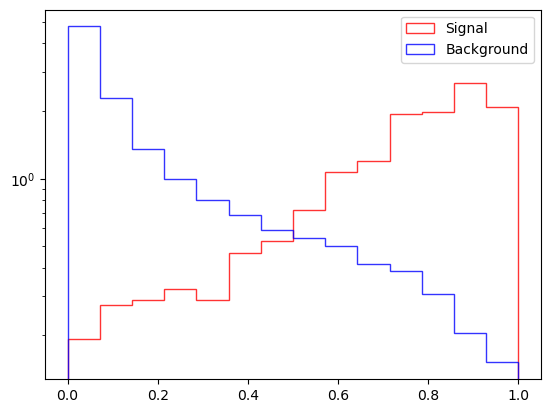

In [22]:
df_test = df[df['mlp_scores'] > 0]
plt.hist(df_test[df_test['label'] == 1]['mlp_scores'], bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.hist(df_test[df_test['label'] == 0]['mlp_scores'], bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.legend()
plt.yscale('log')
plt.show()


In [26]:
sig_hist = plt_to_root_hist_w(df_test[df_test['label'] == 1]['mlp_scores'], 15, 0., 1., None, False)
bkg_hist = plt_to_root_hist_w(df_test[df_test['label'] == 0]['mlp_scores'], 15, 0., 1., None, False)
sig_hist.Scale(1/sig_hist.Integral())
bkg_hist.Scale(1/bkg_hist.Integral())
significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)

1.502563917879391

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


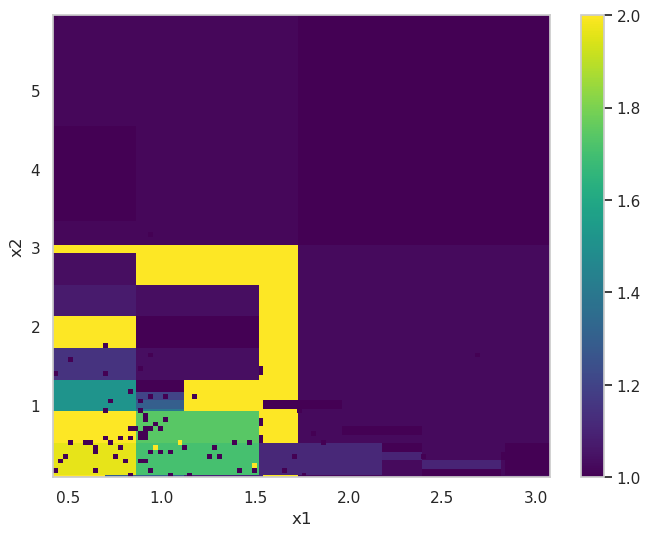

In [21]:
# plot x1 vs x2 in scatter plot. make it a heat map
plt.figure(figsize=(8, 6))

plt.hist2d(ggh_plot['x1'], ggh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(vbfh_plot['x1'], vbfh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(wh_plot['x1'], wh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(zh_plot['x1'], zh_plot['x2'], bins=100, cmap='viridis', cmin=1)
plt.hist2d(tth_plot['x1'], tth_plot['x2'], bins=100, cmap='viridis', cmin=1)

# plt.hist2d(vv_plot['x1'], vv_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(top_plot['x1'], top_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(ztt_plot['x1'], ztt_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(ttv_plot['x1'], ttv_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(w_plot['x1'], w_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(zll_plot['x1'], zll_plot['x2'], bins=50, cmap='viridis', cmin=3)

# plt.hist2d(data_plot['x1'], data_plot['x2'], bins=50, cmap='viridis', cmin=3)



plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()



In [22]:
print(len(ggh_plot[(ggh_plot['x2']<1) & ggh_plot['x2']>0]))


666


In [23]:
print(len(ggh_plot['x1']))


837


In [33]:
print(len(ggh_plot[ggh_plot['collinear_mass']<0]))
print(len(vbfh_plot[vbfh_plot['collinear_mass']<0]))
print(len(wh_plot[wh_plot['collinear_mass']<0]))
print(len(zh_plot[zh_plot['collinear_mass']<0]))
print(len(tth_plot[tth_plot['collinear_mass']<0]))
print(len(vv_plot[vv_plot['collinear_mass']<0]))
print(len(top_plot[top_plot['collinear_mass']<0]))
print(len(ttv_plot[ttv_plot['collinear_mass']<0]))
print(len(w_plot[w_plot['collinear_mass']<0]))
print(len(data_plot[data_plot['collinear_mass']<0]))
print(len(ztt_plot[ztt_plot['collinear_mass']<0]))
print(len(zll_plot[zll_plot['collinear_mass']<0]))




0
0
0
0
0
0
0
0
0
0
0
0


In [96]:
len(vbfh_plot), len(ggh_plot), len(wh_plot), len(zh_plot), len(tth_plot), len(vv_plot), len(top_plot), len(ztt_plot), len(ttv_plot), len(w_plot), len(zll_plot)

(1192, 480, 86, 92, 47, 5174, 34, 108130, 51, 31, 1387)

In [97]:
len(ggh_plot['event_number'])

480

In [98]:
ids = ggh_plot['event_number'] % 5 
#print count how mant ids equal 0, 1, 2, 3, 4
print("ggh", len(ggh_plot[ids == 0])+len(ggh_plot[ids == 1])+len(ggh_plot[ids == 2])+len(ggh_plot[ids == 3])+len(ggh_plot[ids == 4]))

ggh 480


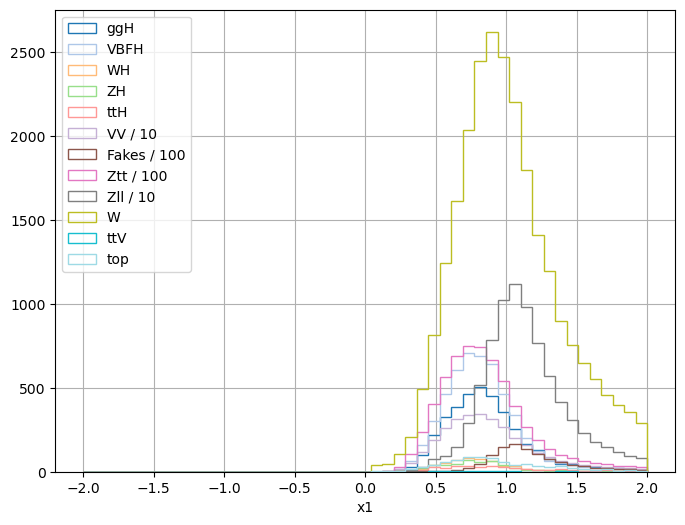

In [34]:
plt.figure(figsize=(8, 6))
plot_int = 'x1'
plt_bins = np.linspace(-2, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

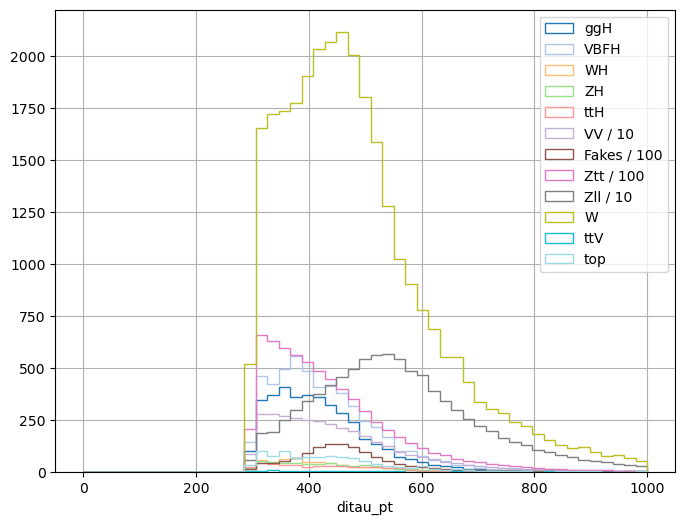

In [35]:
plt.figure(figsize=(8, 6))
plot_int = 'ditau_pt'
plt_bins = np.linspace(0, 1000, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
# plt.hist(np.log(ggh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
# plt.hist(np.log(vbfh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
# plt.hist(np.log(wh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
# plt.hist(np.log(zh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
# plt.hist(np.log(tth_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
# plt.hist(np.log(vv_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
# plt.hist(np.log(data_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
# plt.hist(np.log(ztt_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
# plt.hist(np.log(zll_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
# plt.hist(np.log(w_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
# plt.hist(np.log(ttv_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
# plt.hist(np.log(top_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])


plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

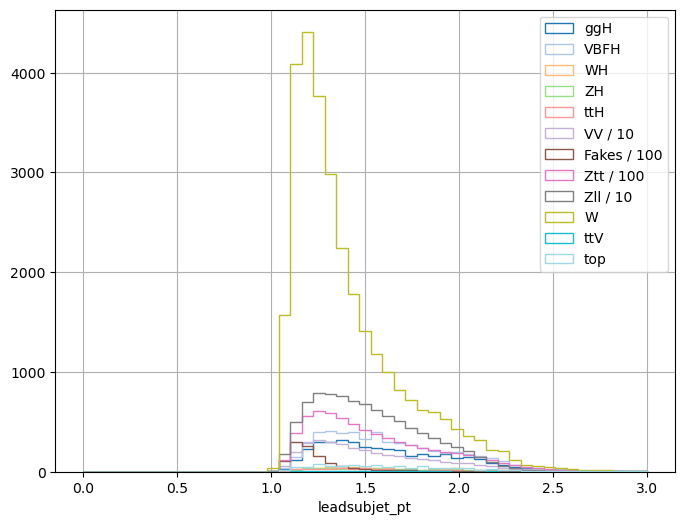

In [36]:
plt.figure(figsize=(8, 6))
plot_int = 'leadsubjet_pt'
plt_bins = np.linspace(0, 3, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot['ditau_pt']/ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot['ditau_pt']/vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot['ditau_pt']/wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot['ditau_pt']/zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot['ditau_pt']/tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot['ditau_pt']/vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot['ditau_pt']/data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot['ditau_pt']/ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot['ditau_pt']/zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot['ditau_pt']/w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot['ditau_pt']/ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot['ditau_pt']/top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

In [66]:
np.log(1 - ggh_plot['ditau_pt']/ggh_plot[plot_int])

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
989   NaN
990   NaN
991   NaN
992   NaN
993   NaN
Length: 994, dtype: float64

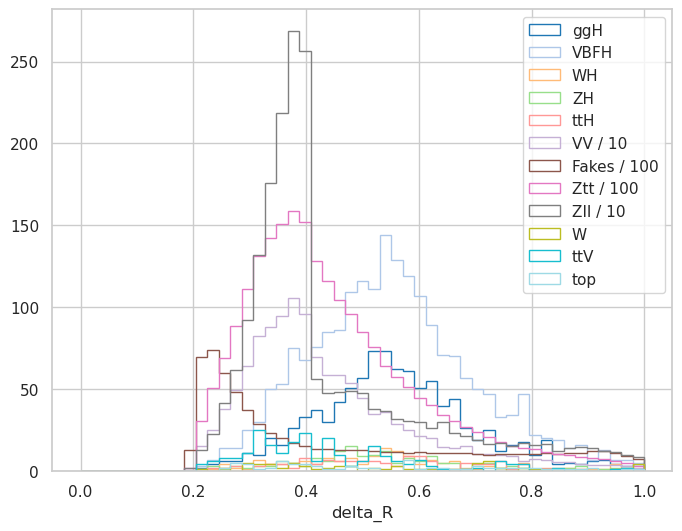

In [21]:
plt.figure(figsize=(8, 6))
plot_int = 'delta_R'
plt_bins = np.linspace(0, 1, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

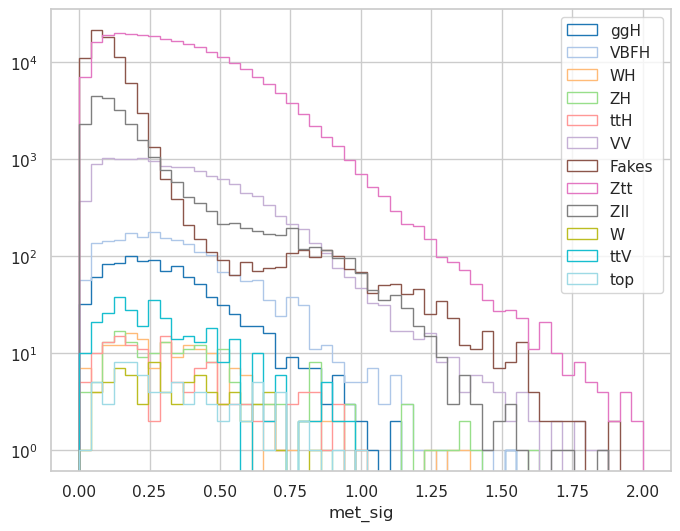

In [28]:
plt.figure(figsize=(8, 6))
plot_int = 'met_sig'
plt_bins = np.linspace(0, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV ', color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes ', color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt ', color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll ', color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

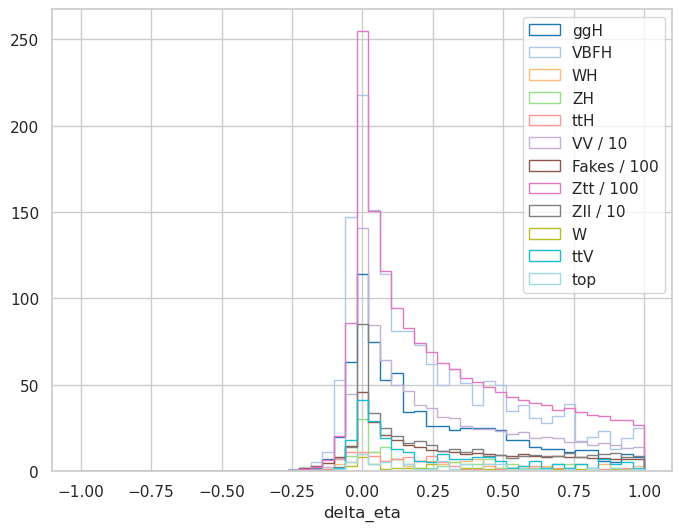

In [49]:
plt.figure(figsize=(8, 6))
plot_int = 'delta_eta'
plt_bins = np.linspace(-1, 1, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100',  weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

In [47]:
# # plot_var = [
# #     'leadsubjet_pT', 'subleadsubjet_pT',
# #     'ditau_m', 'leadsubjet_eta', 'subleadsubjet_eta',
# #     'leadsubjet_phi', 'subleadsubjet_phi'
# # ]
# plot_var = [
# 'leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta'
# ]

# plt.figure(figsize=(40, 36))
# def hist(variable, plot_num):
#     print("Start Plot:", variable)
#     plt.subplot(3, 3, plot_num+1)
#     bin = 50
#     plt.hist(ggh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'ggH ')
#     plt.hist(vbfh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VBFH ')
#     plt.hist(vv_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VV ')
#     # plt.hist(ztt_plot[i], bins=bin, histtype='step', linewidth=1, label=f'Ztt ', weights=np.ones_like(ztt_plot[i])/10)
#     plt.xlabel(variable)
#     #plt.ylabel("Number of Events (scaled)")
#     #plt.title(xlabel)
# #     plt.yscale('log')
#     plt.legend()
#     plt.grid(True)

# for i, label in enumerate(plot_var, 0):
#     hist(label, i)

In [ ]:
ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

# ggh_plt = plt_to_root_hist_w(ggh_plot[2], 10, 0, 150, None, False)
# ggh_plt.SetLineColor(ROOT.kRed)
# ggh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot[2], 10, 0, 150, None, False)
# vbfh_plt.SetLineColor(ROOT.kBlue)
# vbfh_plt.SetMarkerColor(ROOT.kBlue)
# vv_plt = plt_to_root_hist_w(vv_plot[2], 10, 0, 150, None, False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# ztt_plt = plt_to_root_hist_w(ztt_plot[2], 10, 0, 150, None, False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['visible_ditau_m'], vbfh_plot['visible_ditau_m'], wh_plot['visible_ditau_m'], zh_plot['visible_ditau_m'], tth_plot['visible_ditau_m']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 150, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['visible_ditau_m'], ztt_plot['visible_ditau_m'], w_plot['visible_ditau_m'], top_plot['visible_ditau_m'], zll_plot['visible_ditau_m'], ttv_plot['visible_ditau_m'], data_plot['visible_ditau_m']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['visible_ditau_m'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 150, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

# ggh_plt = plt_to_root_hist_w(ggh_plot['visible_ditau_m'], 20, 0, 150, ggh_plot['combined_weights']*lumi_scale_factor, False)
# ggh_plt.SetLineColor(ROOT.kBlue)
# ggh_plt.SetMarkerColor(ROOT.kBlue)
# ggh_plt.SetMarkerStyle(20)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot['visible_ditau_m'], 20, 0, 150, vbfh_plot['combined_weights']*lumi_scale_factor, False)
# vbfh_plt.SetLineColor(ROOT.kRed)
# vbfh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt.SetMarkerStyle(20)
# vh_plt = plt_to_root_hist_w(vh_plot['visible_ditau_m'], 20, 0, 150, vh_plot['combined_weights']*lumi_scale_factor, False)
# vh_plt.SetLineColor(ROOT.kYellow)
# vh_plt.SetMarkerColor(ROOT.kYellow)
# vh_plt.SetMarkerStyle(20)
# wh_plt = plt_to_root_hist_w(wh_plot['visible_ditau_m'], 20, 0, 150, wh_plot['combined_weights']*lumi_scale_factor, False)
# wh_plt.SetLineColor(ROOT.kGreen)
# wh_plt.SetMarkerColor(ROOT.kGreen)
# wh_plt.SetMarkerStyle(20)
# zh_plt = plt_to_root_hist_w(zh_plot['visible_ditau_m'], 20, 0, 150, zh_plot['combined_weights']*lumi_scale_factor, False)
# zh_plt.SetLineColor(ROOT.kOrange)
# zh_plt.SetMarkerColor(ROOT.kOrange)
# zh_plt.SetMarkerStyle(20)
# tth_plt = plt_to_root_hist_w(tth_plot['visible_ditau_m'], 20, 0, 150, tth_plot['combined_weights']*lumi_scale_factor, False)
# tth_plt.SetLineColor(ROOT.kMagenta)
# tth_plt.SetMarkerColor(ROOT.kMagenta)
# tth_plt.SetMarkerStyle(20)

# vv_plt = plt_to_root_hist_w(vv_plot['visible_ditau_m'], 20, 0, 150, vv_plot['combined_weights'], False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# vv_plt.SetMarkerStyle(20)
# ztt_plt = plt_to_root_hist_w(ztt_plot['visible_ditau_m'], 20, 0, 150, ztt_plot['combined_weights'], False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)
# ztt_plt.SetMarkerStyle(20)
# w_plt = plt_to_root_hist_w(W_plot['visible_ditau_m'], 20, 0, 150, W_plot['combined_weights'], False)
# w_plt.SetLineColor(ROOT.kBlack)
# w_plt.SetMarkerColor(ROOT.kBlack)
# w_plt.SetMarkerStyle(20)
# top_plt = plt_to_root_hist_w(Top_plot['visible_ditau_m'], 20, 0, 150, Top_plot['combined_weights'], False)
# top_plt.SetLineColor(ROOT.kGray)
# top_plt.SetMarkerColor(ROOT.kGray)
# top_plt.SetMarkerStyle(20)
# zll_inc_plt = plt_to_root_hist_w(Zll_inc_plot['visible_ditau_m'], 20, 0, 150, Zll_inc_plot['combined_weights'], False)
# zll_inc_plt.SetLineColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerStyle(20)

# ggh_plt.Scale(1. / ggh_plt.Integral())
# vbfh_plt.Scale(1. / vbfh_plt.Integral())
# vv_plt.Scale(1. / vv_plt.Integral())
# ztt_plt.Scale(1. / ztt_plt.Integral())

# ztt_plt.Draw("hist e ")
# zll_inc_plt.Draw("hist e same")
# vv_plt.Draw("hist e same")
# top_plt.Draw("hist e same")
# w_plt.Draw("hist e same")
# vbfh_plt.Draw("hist e same")
# ggh_plt.Draw("hist e same")
# zh_plt.Draw("hist e same")
# wh_plt.Draw("hist e same")
# tth_plt.Draw("hist e same")
# vh_plt.Draw("hist e same")

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_background.Draw("hist e")
all_signal.Draw("hist e same")

all_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
# legend.AddEntry(vv_plt, "VV")
# legend.AddEntry(ztt_plt, "Ztt")
# legend.AddEntry(w_plt, "W")
# legend.AddEntry(top_plt, "Top")
# legend.AddEntry(zll_inc_plt, "Zll_inc")

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [ ]:
%jsroot on

ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['collinear_mass'], vbfh_plot['collinear_mass'], wh_plot['collinear_mass'], zh_plot['collinear_mass'], tth_plot['collinear_mass']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 200, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['collinear_mass'], ztt_plot['collinear_mass'], w_plot['collinear_mass'], top_plot['collinear_mass'], zll_plot['collinear_mass'], ttv_plot['collinear_mass'], data_plot['collinear_mass']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['collinear_mass'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 200, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_signal.Draw("hist e same")
all_background.Draw("hist e same")

all_background.GetXaxis().SetTitle('Collinear Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [43]:
s = (0.1 + 0.001) * np.log(1 + 0.1 / 0.001) - 0.1
s = np.sqrt(2 * s)
s

0.855718612864027

In [26]:
significance_bin_by_bin(all_signal, all_background, s_much_less_than_b=False)

NameError: name 'significance_bin_by_bin' is not defined

In [ ]:
# make root fplot of all signal stracked together and all background stacked together
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#stacked signal
# stacked_signal = ROOT.THStack("stacked_signal", "stacked_signal")
# stacked_signal.Add(ggh_plt)
# stacked_signal.Add(vbfh_plt)
# stacked_signal.Add(vh_plt)
# stacked_signal.Add(wh_plt)
# stacked_signal.Add(zh_plt)
# stacked_signal.Add(tth_plt)

#stacked background
stacked_background = ROOT.THStack("stacked_background", "stacked_background")
stacked_background.Add(vv_plt)
stacked_background.Add(ztt_plt)
stacked_background.Add(w_plt)
stacked_background.Add(top_plt)
stacked_background.Add(zll_inc_plt)

stacked_background.Draw("hist e")
all_signal.Draw("hist e same")

stacked_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
legend.AddEntry(all_signal, "Signal")
legend.AddEntry(vv_plt, "VV")
legend.AddEntry(ztt_plt, "Ztt")
legend.AddEntry(w_plt, "W")
legend.AddEntry(top_plt, "Top")
legend.AddEntry(zll_inc_plt, "Zll")
#make legend text size bigger
legend.SetTextSize(0.02)
#sapce out the markers in the legend
legend.SetMargin(0.5)
#sepreate markers in the legend
legend.SetEntrySeparation(0.1)


legend.Draw()

canvas.Draw()


In [61]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    767489
1      9880
Name: count, dtype: int64

In [62]:
df.loc[df['combined_weights'] < 0, 'combined_weights']

Series([], Name: combined_weights, dtype: float64)

In [82]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [83]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 259279 259090 259000 0 0
Signal Split: 3290 3269 3321 0 0
Background Split: 255989 255821 255679 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'event_number', 'fake_factor', 'combined_weights', 'k_t',
       'delta_R_lead', 'x1', 'x2', 'met_centrality', 'sample_type',
       'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId',
       'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId',
       'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q',
       'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic', 'ids'],
      dtype='object')


len X_train: 518090
len X_test: 259279
signal scaling factor:  77.6176024279211
len X_train: 518279
len X_test: 259090
signal scaling factor:  77.39646044471336
len X_train: 518369
len X_test: 259000
signal scaling factor:  78.03171215124257


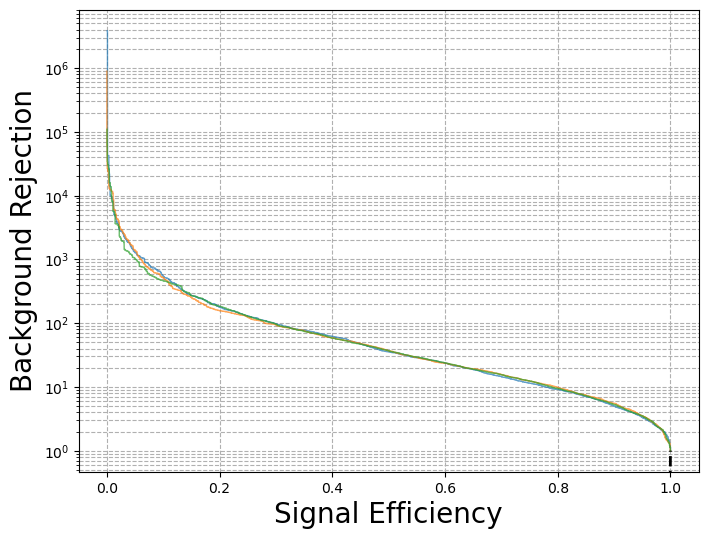

In [84]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []


bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
feature_name_mapping = {
    'ditau_pt': 'ditau_pt',
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'label': 'label',
    'met': 'f5',
    'met_sig': 'f6',
    'event_number': 'event_number',
    'fake_factor': 'fake_factor',
    'combined_weights': 'combined_weights',
    'ids': 'ids',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
    'delta_R_lead': 'f10',
    'delta_phi': 'f11',
    'delta_eta': 'f12',
    'k_t': 'f13'
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }
    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=ff_train*evnt_w_train)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    
    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=ff_test*evnt_w_test)
    tpr = tpr[fpr > 0]
    fpr = fpr[fpr > 0]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



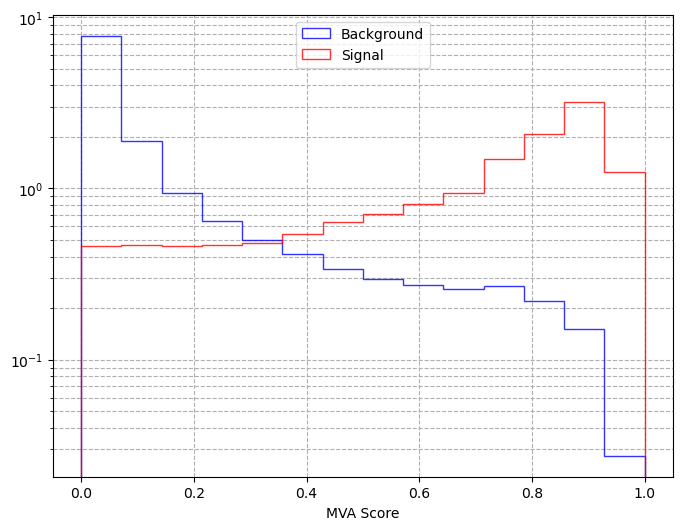

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [64]:
#select df_split[0] for mv score values bigger than 0.8 and label = 0
df_test = df_split[0][(df_split[0]['mva_scores'] > 0.8) & (df_split[0]['label'] == 0) & (df_split[0]['sample_type'] == 'w')]
print(len(df_test))
#print truth variables
#    'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId', 'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId', 'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q', 'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic'

print(df_test['boson_0_classifierParticleOrigin'])
print(df_test['boson_0_mother_pdgId'])
print(df_test['boson_0_mother_status'])
print(df_test['boson_0_pdgId'])
print(df_test['boson_0_truth_pdgId'])
print(df_test['boson_0_truth_q'])
print(df_test['boson_0_truth_status'])
print(df_test['boson_0_q'])
print(df_test['ditau_obj_IsTruthMatched'])  
print(df_test['ditau_obj_IsTruthHadronic'])

#check if ditau_obj_IsTruthHadronic ever equals 1
print(df_test['ditau_obj_IsTruthHadronic'].value_counts())


19
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_classifierParticleOrigin, dtype: float64
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_mother_pdgId, dtype: float64
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_mother_status, dtype: float64
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_pdgId

In [85]:
sig_hist = plt_to_root_hist_w(signal_scores, 15, 0., 1., None, False)
bkg_hist = plt_to_root_hist_w(background_scores, 15, 0., 1., None, False)
sig_hist.Scale(1/sig_hist.Integral())
bkg_hist.Scale(1/bkg_hist.Integral())
significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)

1.7454814702336394

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [62]:
# # Initialize k-fold cross-validation
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# # Initialize lists to store scores
# signal_scores = []
# background_scores = []
# proba_and_values = []
# models = []

# training_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'visible_ditau_m', 'delta_R', 'met', 'label'
# ]
# X = df[training_var[:-1]]  # Features
# print(X.columns)
# y = df['label']  # Target variable

# scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
# print(scale_pos_weight)
# plt.figure(figsize=(8, 6))

# # Iterate through each fold
# # for train_index, test_index in kf.split(X):
# for i, (train_index, test_index) in enumerate(kf.split(X, y)):
#     # Split train and test sets
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     #change column names to f1, f2, f3, f4, f5
#     X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
#     X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
    
#     params = {
#     'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
#     model = XGBClassifier(**params)
#     # Train the model
#     model.fit(X_train, y_train)
#     models.append(model)

#     # Predict probabilities for the test set
#     y_pred_proba = model.predict_proba(X_test)
#     # Extract scores for signal and background
#     signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
#     background_scores.extend(y_pred_proba[:, 1][y_test == 0])

#     # save the proba correspoending to the X_test values
#     proba_and_values.append((y_pred_proba, X_test))

#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')


# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Each Fold')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


In [109]:
# from sklearn.model_selection import cross_val_predict

# params = {
#     'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# model_n = XGBClassifier(**params)

# # Perform cross-validation predictions
# y_pred_proba_cv = cross_val_predict(model_n, X, y, cv=5, method='predict_proba')

# # Get the predicted probabilities for the positive class
# positive_class_proba = y_pred_proba_cv[:, 1]


In [110]:
# plt.figure(figsize=(8, 6))
# plt.hist(positive_class_proba[y == 1], bins=10, alpha=0.8, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(positive_class_proba[y == 0], bins=10, alpha=0.8, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

# sig_hist = plt_to_root_hist_w(positive_class_proba[y == 1], 10, 0., 1., None, False)
# bkg_hist = plt_to_root_hist_w(positive_class_proba[y == 0], 10, 0., 1., None, False)
# sig_hist.Scale(1/sig_hist.Integral())
# bkg_hist.Scale(1/bkg_hist.Integral())
# significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False) ###0.99 with False

In [72]:
import xgboost as xgb
def get_basescore(model: xgb.XGBModel) -> float:
    import json

    """Get base score from an XGBoost sklearn estimator."""
    base_score = float(json.loads(model.get_booster().save_config())["learner"]["learner_model_param"]["base_score"])
    return base_score

print(get_basescore(model)) # usually 0.5

0.5


In [115]:
# # Load the XGBoost model
# trained_model = XGBClassifier()
# trained_model.load_model('xgboost_k_fold_model_v05.bin')

# # calucalte score values with X_train
# y_pred_proba_now = trained_model.predict_proba(X)

# k_fold_y_pred_proba_signal = y_pred_proba_now[:, 1][y == 1]
# k_fold_y_pred_proba_background = y_pred_proba_now[:, 1][y == 0]

In [ ]:
%jsroot on
ROOT.gROOT.SetStyle("ATLAS")

# plot sig_hist and bkg_hist
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#plot signal
sig_hist.SetLineColor(ROOT.kRed)
sig_hist.SetMarkerColor(ROOT.kRed)
sig_hist.SetMarkerStyle(20)
#plot background
bkg_hist.SetLineColor(ROOT.kBlue)
bkg_hist.SetMarkerColor(ROOT.kBlue)
bkg_hist.SetMarkerStyle(20)

#set y axis range 
# bkg_hist.GetYaxis().SetRangeUser(0, 0.42)

sig_hist.Draw("hist e")
bkg_hist.Draw("hist e same")

sig_hist.GetXaxis().SetTitle('Score')

legend = ROOT.TLegend(0.3, 0.7, 0.6, 0.6)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.AddEntry(sig_hist, "Signal")
legend.AddEntry(bkg_hist, "Background")


legend.Draw()

canvas.Draw()



In [128]:
# #split the data into training and testing
# # training_var_s = [
# #     'leadsubjet_pT', 'subleadsubjet_pT',
# #     'visible_ditau_m', 'delta_R'
# # ]
# training_var_s = ['leadsubjet_pT',
#     'subleadsubjet_pT',
#     'visible_ditau_m',
#     'collinear_mass',
#     'delta_R',
#     'met',
#     'met_sig',
#     'delta_phi',
#     'delta_eta'
# ]
# X = df[training_var_s]
# y = df['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

# # print(X_train)
# #save weights in a separate variable
# # weights_train = np.abs(X_train['combined_weights']*lumi_scale_factor)
# # weights_test = np.abs(X_test['combined_weights']*lumi_scale_factor)

# # weights should not be included in the training data
# # X_train.drop(columns='combined_weights', inplace=True)
# # X_test.drop(columns='combined_weights', inplace=True)

# #Change column names to integers if needed (for ML models that expect numerical feature names)
# # feature_mapping = {feature: i for i, feature in enumerate(X_train.columns)}
# # X_train.rename(columns=feature_mapping, inplace=True)
# # X_test.rename(columns=feature_mapping, inplace=True)

# # istead of integers call the vaibels f1, f2, f3, f4
# # X_train.columns = ['f0', 'f1', 'f2', 'f3']
# # X_test.columns = ['f0', 'f1', 'f2', 'f3']
# print(X_train.shape)
# print(X_test.shape)

# #print size of training and testing data
# # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, weights_train.shape, weights_test.shape)
# print(X_train)


In [129]:
# # create the BDT
# params = {
#     'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# bdt = XGBClassifier(**params)

# # Train the classifier
# # bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)], sample_weight=weights_train)
# bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)])


In [130]:
# # plot the ROC curve
# # print(bdt.predict_proba(X_test).shape)
# # print(bdt.predict_proba(X_test))
# print(X_test)
# y_pred = bdt.predict_proba(X_test)[:, 1]
# print(y_pred)
# # fpr, tpr, thresholds = roc_curve(y_test, y_pred, sample_weight=weights_test)
# # roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'(AUC={roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(tpr, 1/fpr, lw=1)
# plt.xlabel('Signal efficiency (TPR)')
# plt.ylabel('Inverse background efficiency (1/FPR)')
# plt.yscale('log')
# plt.grid(True, which="both", ls="--")
# plt.show()

# print(len(y_pred[y_test == 1]), len(y_pred[y_test == 0]))

# signal_scores = y_pred[y_test == 1]
# background_scores = y_pred[y_test == 0]
# plt.figure(figsize=(8, 6))
# plt.hist(signal_scores, bins=10, alpha=0.5, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(background_scores, bins=10, alpha=0.5, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

In [ ]:
# ##### with weights 


# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Hyperparameters
# learning_rate = 0.00008
# batch_size = 128
# dropout = 0
# neuron1 = 64
# neuron2 = 512
# neuron3 = 64
# neuron4 = 64
# neuron5 = 0
# num_epochs =  40

# training_vars = [
#     'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass',
#     'delta_R', 'delta_R_lead', 'met', 'met_sig', 'delta_phi', 'delta_eta', 'k_t'
# ]

# # Split the dataset into training and validation sets
# df['eventID_mod'] = df['event_number'] % 10
# train_loc = df['eventID_mod'] < 7  # 70%
# test_loc = df['eventID_mod'] >= 7  # 30%

# features, labels = df[training_vars].values, df['label'].values
# X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

# event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]


# # Normalize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# # X_train_scaled = X_train
# # X_val_scaled = X_val

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     print("Using GPU")

# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
#         super(MLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, neuron1),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron1, neuron2),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron2, neuron3),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron3, neuron4),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron4, 1),
#             # nn.GELU(),
#             # nn.Dropout(dropout),
#             # nn.Linear(neuron5, 1)
#         )

#     def forward(self, x):
#         return self.layers(x)

# # Convert data to PyTorch tensors and move to GPU if available
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
# event_weight_train_tensor = torch.tensor(event_weight_train, dtype=torch.float32).view(-1, 1).to(device)
# event_weight_val_tensor = torch.tensor(event_weight_val, dtype=torch.float32).view(-1, 1).to(device)



# # Create DataLoader for batch training
# train_data = TensorDataset(X_train_tensor, y_train_tensor, event_weight_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# # Initialize the MLP model and move to GPU if available
# model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)

# # Calculate class weights
# n_background = np.sum(y_train == 0)
# n_signal = np.sum(y_train == 1)
# # weight_for_0 = (1 / n_background) * ((n_background + n_signal) / 2)
# # weight_for_1 = (1 / n_signal) * ((n_background + n_signal) / 2)

# # Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([n_background / n_signal]).to(device))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# # Early stopping function
# def early_stopping(val_loss_list, patience=5):
#     if len(val_loss_list) > patience:
#         if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
#             return True
#     return False

# # Training loop
# best_val_loss = float('inf')
# val_loss_list = []
# train_loss_list = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for inputs, labels, batch_weights in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss = (loss * batch_weights).mean()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_loss_list.append(avg_train_loss)
    
#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_val_tensor)
#         val_loss = criterion(val_outputs, y_val_tensor).item()
    
#     val_loss_list.append(val_loss)
#     scheduler.step(val_loss)
    
#     print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')
    
#     if early_stopping(val_loss_list):
#         print("Early stopping")
#         break



In [34]:
# Hyperparameters
learning_rate = 0.000064
batch_size = 64
dropout = 0
neuron1 = 64
neuron2 = 64
neuron3 = 512
neuron4 = 64
neuron5 = 0
num_epochs = 30

training_vars = [
    'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass', 'k_t',
    'delta_R', 'delta_R_lead', 'met', 'met_sig', 'x1', 'x2', 'met_centrality'
]

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, neuron1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron1, neuron2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron2, neuron3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron3, neuron4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron4, 1),
            # nn.GELU(),
            # nn.Dropout(dropout),
            # nn.Linear(neuron5, 1)
        )

    def forward(self, x):
        return self.layers(x)
    
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")
model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)


Using GPU


In [35]:
# # Split the dataset into training and validation sets
# df['eventID_mod'] = df['event_number'] % 10
# train_loc = df['eventID_mod'] < 7  # 70%
# test_loc = df['eventID_mod'] >= 7  # 30%

# features, labels = df[training_vars].values, df['label'].values
# X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]
# print("len X_train:", len(X_train))
# print("len X_val:", len(X_val))

# event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]
# ff_train, ff_val = df['fake_factor'].values[train_loc], df['fake_factor'].values[test_loc]
# total_weight_train = event_weight_train*ff_train
# total_weight_val = event_weight_val*ff_val

# # Normalize features
# # scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_val_scaled = scaler.transform(X_val)
# X_train_scaled = X_train
# X_val_scaled = X_val

# # Convert data to PyTorch tensors and move to GPU if available
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# X_val_event_numbers = df['event_number'].values[test_loc]

# # Create DataLoader for batch training
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [36]:
# # Calculate class weights
# n_background = np.sum(y_train == 0)
# n_signal = np.sum(y_train == 1)
# # weight_for_0 = (1 / n_background) * ((n_background + n_signal) / 2)
# # weight_for_1 = (1 / n_signal) * ((n_background + n_signal) / 2)

# # Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([n_background / n_signal]).to(device))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# # Early stopping function
# def early_stopping(val_loss_list, patience=5):
#     if len(val_loss_list) > patience:
#         if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
#             return True
#     return False

# # Training loop
# best_val_loss = float('inf')
# val_loss_list = []
# train_loss_list = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_loss_list.append(avg_train_loss)
    
#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_val_tensor)
#         val_loss = criterion(val_outputs, y_val_tensor).item()
    
#     val_loss_list.append(val_loss)
#     scheduler.step(val_loss)
    
#     print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')
    
#     if early_stopping(val_loss_list):
#         print("Early stopping")
#         break



In [37]:
# Preparing the data
df['eventID_mod'] = df['event_number'] % 10
train_loc = df['eventID_mod'] < 7  # 70%
test_loc = df['eventID_mod'] >= 7  # 30%

features, labels = df[training_vars].values, df['label'].values
X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]
ff_train, ff_val = df['fake_factor'].values[train_loc], df['fake_factor'].values[test_loc]
total_weight_train = event_weight_train * ff_train
total_weight_val = event_weight_val * ff_val

# Normalize features if needed
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
X_train_scaled = X_train
X_val_scaled = X_val

print("shape of X_train_scaled: ", X_train_scaled.shape)
print("shape of X_val_scaled: ", X_val_scaled.shape)

# Convert data to PyTorch tensors and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
total_weight_train_tensor = torch.tensor(total_weight_train, dtype=torch.float32).to(device)

# Create DataLoader for batch training
train_data = TensorDataset(X_train_tensor, y_train_tensor, total_weight_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Calculate class weights
n_background = np.sum(y_train == 0)
n_signal = np.sum(y_train == 1)
pos_weight = torch.tensor([n_background / n_signal]).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')  # Use reduction='none' to apply weights
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early stopping function
def early_stopping(val_loss_list, patience=5):
    if len(val_loss_list) > patience:
        if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
            return True
    return False

# Training loop
best_val_loss = float('inf')
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels, weights in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        weighted_loss = loss * weights.view(-1, 1)  # Apply event weights
        weighted_loss = weighted_loss.mean()  # Mean the loss over the batch
        weighted_loss.backward()
        optimizer.step()
        train_loss += weighted_loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        weighted_val_loss = val_loss * torch.tensor(total_weight_val, dtype=torch.float32).to(device).view(-1, 1)
        weighted_val_loss = weighted_val_loss.mean().item()
    
    val_loss_list.append(weighted_val_loss)
    scheduler.step(weighted_val_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {weighted_val_loss:.4f}')
    
    if weighted_val_loss < best_val_loss:
        best_val_loss = weighted_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if early_stopping(val_loss_list):
        print("Early stopping")
        break


shape of X_train_scaled:  (172502, 12)
shape of X_val_scaled:  (73829, 12)
Epoch: 1, Train Loss: 0.0056, Val Loss: 0.0063
Epoch: 2, Train Loss: 0.0051, Val Loss: 0.0047
Epoch: 3, Train Loss: 0.0048, Val Loss: 0.0047
Epoch: 4, Train Loss: 0.0046, Val Loss: 0.0046
Epoch: 5, Train Loss: 0.0044, Val Loss: 0.0040
Epoch: 6, Train Loss: 0.0042, Val Loss: 0.0040
Epoch: 7, Train Loss: 0.0042, Val Loss: 0.0041
Epoch: 8, Train Loss: 0.0041, Val Loss: 0.0038
Epoch: 9, Train Loss: 0.0040, Val Loss: 0.0039
Epoch: 10, Train Loss: 0.0040, Val Loss: 0.0038
Epoch: 11, Train Loss: 0.0039, Val Loss: 0.0037
Epoch: 12, Train Loss: 0.0039, Val Loss: 0.0040
Epoch: 13, Train Loss: 0.0039, Val Loss: 0.0037
Epoch: 14, Train Loss: 0.0038, Val Loss: 0.0038
Epoch: 15, Train Loss: 0.0038, Val Loss: 0.0037
Epoch: 16, Train Loss: 0.0038, Val Loss: 0.0037
Epoch: 17, Train Loss: 0.0037, Val Loss: 0.0037
Epoch: 18, Train Loss: 0.0038, Val Loss: 0.0038
Epoch: 19, Train Loss: 0.0037, Val Loss: 0.0037
Epoch: 20, Train Loss:

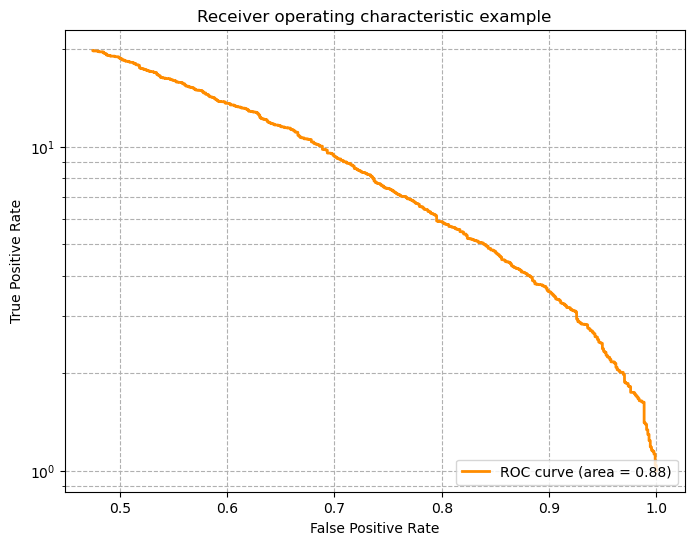

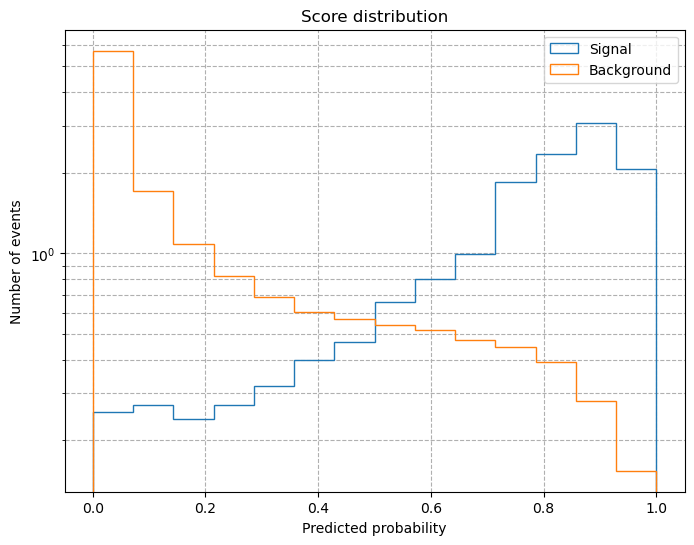

In [38]:
# load best model   
model.load_state_dict(torch.load('best_model.pth'))

# After training the model, get the predicted probabilities for the validation set
model.eval()
with torch.no_grad():
    y_val_pred = torch.sigmoid(model(X_val_tensor)).cpu().numpy().flatten()

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_val_pred)

#select fpr bigger than 0
tpr = tpr[fpr > 0.05]
fpr = fpr[fpr > 0.05]

roc_auc = auc(fpr, tpr)


# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
# plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss vs Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(tpr, 1/fpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot the score distribution for signal and background
plt.figure(figsize=(8, 6))
plt.hist(y_val_pred[y_val == 1], bins=np.linspace(0, 1, 15), label='Signal', histtype='step', density=True)
plt.hist(y_val_pred[y_val == 0], bins=np.linspace(0, 1, 15), label='Background', histtype='step', density=True)
plt.yscale('log')
plt.xlabel('Predicted probability')
plt.ylabel('Number of events')
plt.title('Score distribution')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="--")
plt.show()


In [48]:
from multiprocessing import Pool, cpu_count
import traceback

#path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/mc/ditau_hh/mc20e/nom/user.shhirose.Httbst_b6.mc20_13TeV.700793.Sh_2214_Ztt_maxHTpT_CFBV.PHYS.r13145_p5855.smPre_w_1_HS/*.root'
#path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/mc/ditau_hh/mc20e/nom/user.shhirose.Httbst_b6.mc20_13TeV.700792.Sh_2214_Ztt_maxHTpT_BF.PHYS.r13145_p5855.smPre_w_1_HS/*.root'
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/mc/ditau_hh/mc20e/nom/user.shhirose.*.*/user.*.root'
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/*.root'
output_dir = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/'

histogram_names = [
    "cutflow_muon_NOMINAL", "cutflow_ele_NOMINAL", "cutflow_pho_NOMINAL",
    "cutflow_tau_NOMINAL", "cutflow_jet_NOMINAL", "cutflow_HSM_common",
    "h_metadata", "h_metadata_theory_weights"
]

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

def process_file(args):
    file_path, test_scores, event_index_map, path_template, output_dir = args
    file = None
    try:
        file = ROOT.TFile.Open(file_path, "READ")
        if not file or file.IsZombie():
            print(f"Error: Unable to open file {file_path}")
            return

        tree = file.Get("NOMINAL")
        num_entries = tree.GetEntries()
        
        relative_path = os.path.relpath(file_path, os.path.commonpath([file_path, path_template.split('*')[0]]))
        output_file_path = os.path.join(output_dir, relative_path)
        output_file_dir = os.path.dirname(output_file_path)
        os.makedirs(output_file_dir, exist_ok=True)
        
        output_file = ROOT.TFile.Open(output_file_path, "RECREATE")
        new_tree = tree.CloneTree(0)
        
        scores = array('f', [0.0])
        new_tree.Branch("mlp_scores", scores, 'mlp_scores/F')
        
        for i in range(num_entries):
            tree.GetEntry(i)
            event_number = tree.event_number
            
            if event_number in event_index_map:
                scores[0] = test_scores[event_index_map[event_number]]
            else:
                scores[0] = -1.0
            
            new_tree.Fill()
        
        new_tree.Write()

        for hist_name in histogram_names:
            hist = file.Get(hist_name)
            if hist:
                hist_clone = hist.Clone()
                hist_clone.Write()

        output_file.Close()
        print(f"File saved: {output_file_path}")
        
    except Exception as e:
        print(f"Error processing file {file_path}:")
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        print(traceback.format_exc())
    finally:
        if file:
            file.Close()

# Compute scores once (make sure this is defined correctly in your actual code)
test_scores = y_val_pred

# Create a mapping from event numbers to their indices in X_val_event_numbers
event_index_map = {event_num: idx for idx, event_num in enumerate(X_val_event_numbers)}

# Gather files
mc_files = glob.glob(path_template)
data_files = glob.glob(path_template_data)
all_files = [(file, test_scores, event_index_map, path_template, output_dir) for file in mc_files + data_files]
print(f"Found {len(mc_files)} MC files and {len(data_files)} data files")

with Pool(cpu_count()) as pool:
    pool.map(process_file, all_files)


Found 313 MC files and 280 data files
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.346191.PoPy8_NNPDF30_VBFH125_ttlm15hp20.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38630540._000001.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.304014.MadPy8_3top_SM.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38631320._000001.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.700792.Sh_2214_Ztt_maxHTpT_BF.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38630645._000001.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.700792.Sh_2214_Ztt_maxHTpT_BF.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38630645._000003.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_

In [87]:

# Export the model
torch.onnx.export(model,               # model being run
                  X_val_tensor,                         # model input (or a tuple for multiple inputs)
                  "mva_mlp.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['X'],   # the model's input names
                  output_names = ['Y'], # the model's output names
                  dynamic_axes={'X' : {0 : 'batch_size'},    # variable length axes
                                'Y' : {0 : 'batch_size'}})

In [88]:
import onnx

onnx_model = onnx.load("mva_mlp.onnx")
onnx.checker.check_model(onnx_model)

In [94]:
import onnxruntime

torch_out = model(X_val_tensor)

ort_session = onnxruntime.InferenceSession("mva_mlp.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(X_val_tensor)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


[array([[-4.904828 ],
       [ 3.1654897],
       [-2.3223598],
       ...,
       [-0.8264936],
       [ 1.7189206],
       [-1.1022711]], dtype=float32)]
Exported model has been tested with ONNXRuntime, and the result looks good!


In [95]:
torch_out

tensor([[-4.9048],
        [ 3.1655],
        [-2.3224],
        ...,
        [-0.8265],
        [ 1.7189],
        [-1.1023]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [63]:
sig_hist_mlp = plt_to_root_hist_w(y_val_pred[y_val == 1].cpu().numpy(), 5, 0., 1., None, False)
bkg_hist_mlp = plt_to_root_hist_w(y_val_pred[y_val == 0].cpu().numpy(), 5, 0., 1., None, False)
sig_hist_mlp.Scale(1/sig_hist_mlp.Integral())
bkg_hist_mlp.Scale(1/bkg_hist_mlp.Integral())

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [65]:

# sig_hist_mlp.ROOT.Chi2Test(bkg_hist_mlp,"WW",res)
# res = sig_hist_mlp.Chi2Test(bkg_hist_mlp, "WW P")
chi2 = bkg_hist_mlp.Chi2Test(sig_hist_mlp, "WW P")


Chi2 = 3062.806806, Prob = 0, NDF = 4, igood = 0


In [66]:
chi2

0.0